<a href="https://colab.research.google.com/github/edliu2/UsedCarsProject/blob/master/kPCA_LinearReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Initial modelling to determine # of components

In [3]:
Ny_components = 2000 # number of samples in Nystroem subset, also number of components created
                     # limited by the available RAM 
                     # use <=1000 for Colab instance (12GB RAM)
                     # 4000 worked on GCP instance (64GB RAM)

In [4]:
# Approximate Kernel PCA using Nystroem

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [5]:
# Import required libraries for approximate Kernel PCA
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA

#Normalizing the features
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# Nystroem approximation on a subset of data
# (used because kernelPCA is not feasible on the large dataset)
Ny = Nystroem(n_components=Ny_components, random_state=0)
X_train = Ny.fit_transform(X_train)
X_test = Ny.transform(X_test)

#Linear PCA
PCAObj = PCA(n_components=None, random_state=0)
X_train = PCAObj.fit_transform(X_train)
X_test = PCAObj.transform(X_test)


Number of components with 0.95 cumulative variance:  209


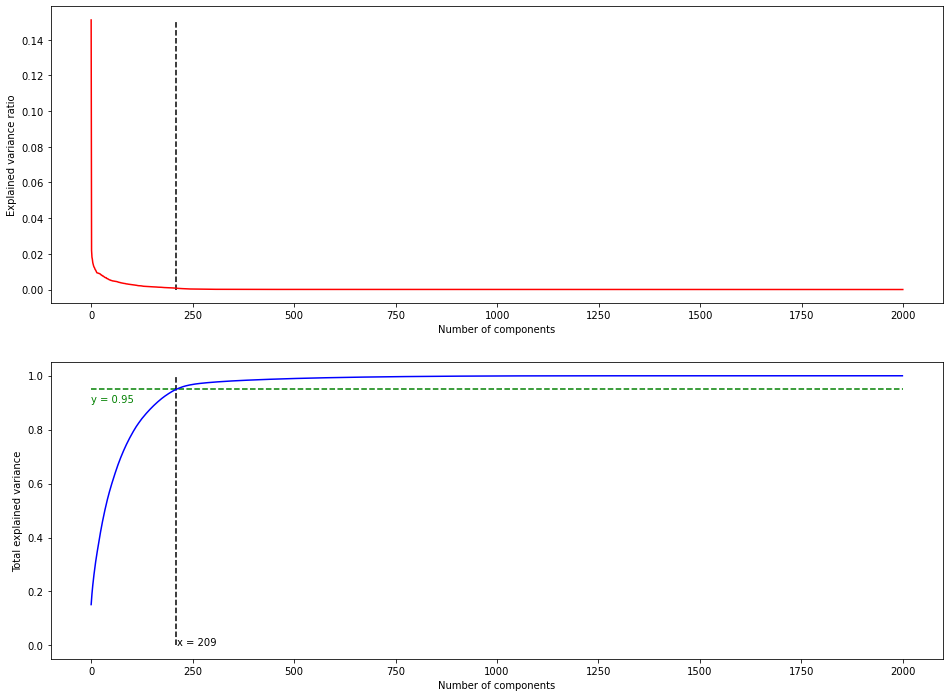

In [6]:
# Define cumulative explained variance ratio
total_variance = np.cumsum(PCAObj.explained_variance_ratio_)

# Show when total_variance is 0.95 using a plot
plt.figure(1, figsize=[16,12])
plot1 = plt.subplot(211)
plt.plot(PCAObj.explained_variance_ratio_, c='red')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

plot2 = plt.subplot(212)
plt.plot(total_variance, c='blue')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
# Look for where cumulative explained variance is 0.95
expl_95_index = np.where((total_variance > 0.949) & (total_variance < 0.951))[0][0]
print('Number of components with 0.95 cumulative variance: ', expl_95_index)
plt.hlines(0.95, 0, len(total_variance), linestyles='dashed', color='green')
plt.vlines(expl_95_index, 0, 1, linestyles='dashed')
plot1.vlines(expl_95_index, 0, np.max(PCAObj.explained_variance_ratio_), linestyles='dashed')
plt.text(0, 0.95-0.05, 'y = 0.95', color='green')
plt.text(expl_95_index+2, 0, 'x = '+str(expl_95_index))

plt.show()

# Clear variables except the index and Ny_components to "reset" the runtime

In [7]:
%reset_selective -f ^(?!expl_95_index|Ny_components).*$ 

## Run PCA with the # of components from above

In [8]:
#Kernal PCA (Nystroem approximation)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Loading the dataset
try:
  dataset = pd.read_csv('drive/My Drive/processed.csv')
except:
  dataset = pd.read_csv('processed.csv')

# print(dataset)

X = dataset.iloc[:,2:].values #We are not using column 1. Also we slice it this way because we want X to be a matrix
y = dataset.iloc[:,1].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [10]:
# Import required libraries for making a PCA pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline for predicting the target
RF_PCA_pipeline = Pipeline([
                    ('scale', StandardScaler()), 
                    ('Ny', Nystroem(n_components=Ny_components, random_state=0)),
                    ('PCA', PCA(n_components=expl_95_index, random_state=0)),
                    ('random_forest', RandomForestRegressor(random_state=0, n_estimators=10))
                     ], verbose=True)

grid_param = dict(random_forest__min_samples_leaf=[8,16,32,48],
                  random_forest__bootstrap=[True,False])
searchObj = GridSearchCV(RF_PCA_pipeline, grid_param, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=10)
searchObj.fit(X_train, y_train)
y_pred = searchObj.predict(X_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 69.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 89.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 110.3min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed: 165.3min remaining: 13.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 166.6min finished


[Pipeline] ............. (step 1 of 4) Processing scale, total=   3.2s
[Pipeline] ................ (step 2 of 4) Processing Ny, total=  28.0s
[Pipeline] ............... (step 3 of 4) Processing PCA, total=  38.9s
[Pipeline] ..... (step 4 of 4) Processing random_forest, total= 8.1min


In [11]:
# Evaluating the model
print(mean_squared_error(y_test, y_pred))

print(10**y_test)
print(10**y_pred)
print(mean_squared_error(10**y_test, 10**y_pred))

0.04287946927349297
[ 1300. 10900.  8200. ... 12800.  7500.  3500.]
[  596.45660441 13311.98569273 10758.77244215 ... 15173.44783019
 10057.73924049  3877.37743028]
58628144.88900101


In [12]:
print(searchObj.best_params_)

{'random_forest__bootstrap': True, 'random_forest__min_samples_leaf': 8}


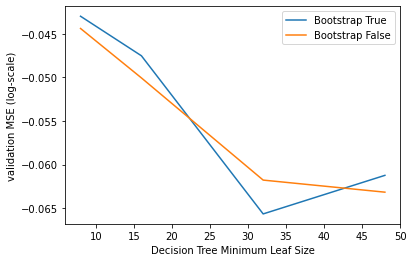

In [19]:
plt.plot(grid_param['random_forest__min_samples_leaf'], searchObj.cv_results_['mean_test_score'].reshape(4,2))
plt.ylabel('validation MSE (log-scale)')
plt.xlabel('Decision Tree Minimum Leaf Size')
plt.legend(('Bootstrap True', 'Bootstrap False'))
plt.show()

In [15]:
print(searchObj.cv_results_) # 4 true then 4 false

{'mean_fit_time': array([ 860.68234608,  831.65841589,  803.71851158,  771.84184527,
       1224.29380484, 1164.56404448, 1115.97804136, 1078.44388468]), 'std_fit_time': array([ 9.98233539, 14.61076898, 16.01630267,  8.54521895, 11.25702971,
       19.76944843, 19.26978512,  9.44378505]), 'mean_score_time': array([16.04355416, 13.74444447, 13.24606683, 12.64122586, 13.2256705 ,
       13.6114974 , 13.36759188, 10.13246899]), 'std_score_time': array([3.00583258, 1.80988153, 1.08356447, 1.07425964, 1.13224469,
       0.68816783, 0.78660765, 2.87188018]), 'param_random_forest__bootstrap': masked_array(data=[True, True, True, True, False, False, False, False],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_random_forest__min_samples_leaf': masked_array(data=[8, 16, 32, 48, 8, 16, 32, 48],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=o